<h2>Check motif enrichment</h2>

In [1]:
using Gadfly
using SeqUtils
using PerformanceEval

<h3>Define functions</h3>

In [2]:
sharedDataDir = "/projects/leelab/data/pure-seq"

type ChromosomePosition
    chr::ASCIIString
    pos::Int64
    value::Float64
end

function read_peaks(f, format)
    positions = ChromosomePosition[]
    for line in eachline(f)
        parts = split(line)
        if parts[1][1] == '#' continue end
        
        if format == "narrowPeak"
            push!(positions, ChromosomePosition(parts[1], int((int(parts[2])+int(parts[2]))/2), float(parts[8])))
        elseif format == "FIMO"
            push!(positions, ChromosomePosition(parts[2], int((int(parts[3])+int(parts[4]))/2), float(parts[6])))
        elseif format == "bed2"
            push!(positions, ChromosomePosition(parts[1], int((int(parts[2])+int(parts[3]))/2), float(parts[4])))
        elseif format == "bed"
            push!(positions, ChromosomePosition(parts[1], int((int(parts[2])+int(parts[3]))/2), float(parts[5])))
        end
    end
    sort!(positions, by=x->-x.value)
end

function testoverlap(position::ChromosomePosition, intervals::Array{ChromosomeInterval,1})
    for intr in intervals
        if intr.chromosome == position.chr && position.pos <= intr.last && position.pos >= intr.first
            return true
        end
    end
    
    false
end

function find_distance(position, positions)
    minDist = 100000000
    for i in 1:length(positions)
        if position.chr == positions[i].chr && abs(position.pos - positions[i].pos) < minDist
            minDist = abs(position.pos - positions[i].pos)
        end
    end
    minDist
end

function load_blackList_intervals(f)
    intervals = ChromosomeInterval[]
    for line in eachline(f)
        parts = split(line)
        if parts[1][1] == '#' continue end
        
        push!(intervals, ChromosomeInterval (parts[1], int(parts[2]), int(parts[3])))
    end
    intervals
end

function score_peaks(peaks, motifs; blacklist=true, matchDistance=500)
    
    # clean out peaks in blacklist regions
    if blacklist
        blacklistIntervals = open(load_blackList_intervals, "$sharedDataDir/wgEncodeDacMapabilityConsensusExcludable_hg38.bed")
        peaksClean = ChromosomePosition[]
        for i in 1:length(peaks)
            if !testoverlap(peaks[i], blacklistIntervals)
                push!(peaksClean, peaks[i])
            end
        end
        peaks = peaksClean
    end
    
    # get each peak's distance to a motif
    dists = Float64[]
    for i in 1:length(peaks)
        push!(dists, find_distance(peaks[i], motifs))
    end
    
    rank_precision(dists .<= matchDistance)
end

function plot_scores(data)
    
    # find the shortest list
    minLength = minimum([length(v[1]) for v in values(data)])
    
    plot(
        x=[[v[1][1:minLength] for v in values(data)]...],
        y=[[v[2][1:minLength] for v in values(data)]...],
        color=[[[k for i in 1:minLength] for k in keys(data)]...],
        Geom.line,
        Guide.xlabel("ranked peak centers"),
        Guide.ylabel("proportion close to motif"),
        Guide.title(join(keys(data), " vs. "))
    )
end

plot_scores (generic function with 1 method)

<h3>Check the common processed data from ENCODE against MACS2 with matched control</h3>

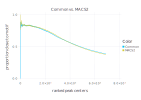

In [3]:
motifs = open(f->read_peaks(f, "FIMO"), "$sharedDataDir/REST_MA0138.2_FIMO_p6.txt")
bigDataDir = "/scratch2/slund1/ENCSR000BQS_local"
plot_scores([
    "Common" => score_peaks(open(f->read_peaks(f, "bed2"), "$sharedDataDir/ENCFF002CHH_hg38.bed"), motifs),
    "MACS2" => score_peaks(open(f->read_peaks(f, "bed"), "$bigDataDir/local_remap2_pooled_q01_summits.bed"), motifs)
])

<h3>Compare MACS2 with PureSeq7 forward control vs. matched control</h3>

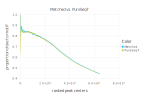

In [6]:
motifs = open(f->read_peaks(f, "FIMO"), "$sharedDataDir/REST_MA0138.2_FIMO_p6.txt")
bigDataDir = "/scratch2/slund1/ENCSR000BQS_notebook"
plot_scores([
    "Matched" => score_peaks(open(f->read_peaks(f, "bed"), "$bigDataDir/ENCFF000NYK_matched_ENCFF000ODO_summits.bed"), motifs),
    "PureSeq7" => score_peaks(open(f->read_peaks(f, "bed"), "$bigDataDir/ENCFF000NYK_pred7_w50_summits.bed"), motifs)
])

<h3>Compare MACS2 with PureSeq35 forward and reverse control vs. matched control</h3>

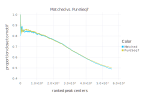

In [7]:
motifs = open(f->read_peaks(f, "FIMO"), "$sharedDataDir/REST_MA0138.2_FIMO_p6.txt")
bigDataDir = "/scratch2/slund1/ENCSR000BQS_notebook"
plot_scores([
    "Matched" => score_peaks(open(f->read_peaks(f, "bed"), "$bigDataDir/ENCFF000NYK_matched_ENCFF000ODO_summits.bed"), motifs),
    "PureSeq7" => score_peaks(open(f->read_peaks(f, "bed"), "$bigDataDir/ENCFF000NYK_pred35fr_w50_summits.bed"), motifs)
])

In [ ]:
#run(`macs2 callpeak -t ENCFF000NYK.bam -c ENCFF000NYK_pred7_w50.bam --q 0.01 -f BAM -g hs -n ENCFF000NYK_pred7_w50`)

In [ ]:
# peaksCommon = open(f->read_peaks(f, "bed2"), "$dataDir/ENCFF002CHH_hg38.bed")
# #peaksMACSB = GZip.open(f->read_peaks(f, "narrowPeak"), "$dataDir/ENCSR000BQS.peaks.narrowPeak.gz")
# #peaksMACS = open(f->read_peaks(f, "narrowPeak"), "$dataDir/ENCSR000BQS_peak.narrowPeak")
# #peaksMACSA = open(f->read_peaks(f, "bed2"), "$dataDir/test_peaks_hg38.bed")
# peaksMACSA = open(f->read_peaks(f, "bed"), "/scratch2/slund1/ENCSR000BQS_local/local_remap2_pooled_q01_summits.bed")
# #peaksMACSA = open(f->read_peaks(f, "bed"), "/scratch2/slund1/ENCSR000BQS_local/local_pooled_q001_summits.bed")
# peaksMACSB = open(f->read_peaks(f, "bed"), "/scratch2/slund1/ENCSR000BQS_local/local_pooled_q01_summits.bed")
# #peaksMACS = open(f->read_peaks(f, "narrowPeak"), "$dataDir/ENCSR000BQS_hg38peaks.narrowPeak")
# motifs = open(f->read_peaks(f, "FIMO"), "$dataDir/REST_MA0138.2_FIMO_p6.txt");